## Data Preparation

In [1]:
import logging

import scgen
import numpy as np
import scanpy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

Global seed set to 0
C:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\CSC2431 Artificial Intelligence in Medicine\Week 3\sc_env\lib\site-packages\pytorch_lightning\utilities\warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
C:\Users\PavloBilinskyi\OneDrive - Ladoburn Europe Ltd\Documents\Documents (onedrive)\Education\master\CSC2431 Artificial Intelligence in Medicine\Week 3\sc_env\lib\site-packages\pytorch_lightning\utilities\warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` i

In [19]:
train = sc.read("./tests/data/train_kang.h5ad",
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))].copy()

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# from VariationalAutoencoder import *


np.random.seed(43)


class scDataset(Dataset):
    def __init__(self, ann_array, transform=None):
        self.X = ann_array.to_df().values
        self.y = ann_array.obs['condition'].apply(lambda x: 0 if x == 'control' else 1).values
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx, :], self.y[idx]
    
    
    
        
def get_sample(adata, sample_size=1000):
    '''
        Get a sample of a given size from AnnData array
    '''
    barcodes = adata.obs.index.values
    return train_new[np.random.choice(barcodes, sample_size), :]
        


## Custom VAE

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.utils.data
import torch.distributions
from torch.distributions import Normal
import torchvision
from torch.distributions import kl_divergence



plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')


device: cpu


### Final Implementation for single-cell data

In [5]:
class FCLayers(nn.Module):
    def __init__(self, n_input, n_layers, n_hidden, dropout_rate):
        super(FCLayers, self).__init__()
        modules = []
        hidden_dims = [n_hidden]*n_layers
        for in_size, out_size in zip([n_input]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size, bias=True))
            modules.append(nn.BatchNorm1d(out_size, momentum=0.01, eps=0.001))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=dropout_rate))
        # modules.append(nn.Linear(hidden_dims[-1], out_dim))   # do not add fine layer to latent space
        self.fc = nn.Sequential(*modules)

    def forward(self, *inputs):
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)

In [6]:



class Encoder(nn.Module):
    def __init__(self, n_input, n_layers, n_hidden, n_latent, dropout_rate=0.1, distribution='normal'):
        super(Encoder, self).__init__()
        self.fc = FCLayers(n_input, n_layers, n_hidden, dropout_rate)
        self.mean_encoder = nn.Linear(n_hidden, n_latent)
        self.var_encoder = nn.Linear(n_hidden, n_latent)
        self.var_activation = torch.exp
        
    def forward(self, x, *cat_list):
        q = self.fc(x)
        qz_m = self.mean_encoder(q)
        qz_v = self.var_activation(self.var_encoder(q))  # we often apply an activation function exp() on variation to ensure positivity (more: https://avandekleut.github.io/vae/)
        
        latent = Normal(qz_m, torch.sqrt(qz_v)).rsample() # reparametrized sample, allows differentiation (see more: https://stackoverflow.com/questions/60533150/what-is-the-difference-between-sample-and-rsample)
        
        return qz_m, qz_v, latent
    
    
class Decoder(nn.Module):
    def __init__(self, n_latent, n_layers, n_hidden, n_output, dropout_rate=0.2):
        super(Decoder, self).__init__()
        self.fc = FCLayers(n_latent, n_layers, n_hidden, dropout_rate)
        self.linear_out = nn.Linear(n_hidden, n_output) # the last layer - to map results of FC neural network to original space, decode
    
    def forward(self, x, *cat_list):
        p = self.linear_out(self.fc(x, *cat_list))
        return p
    

class VAE(nn.Module):
    def __init__(self, n_input, n_layers, n_hidden, n_latent, kl_weight=0.00005):
        super(VAE, self).__init__()
        self.encoder = Encoder(n_input, n_layers, n_hidden, n_latent)
        self.decoder = Decoder(n_latent, n_layers, n_hidden, n_output=n_input)
        
        self.kl_weight = kl_weight
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    
    def forward(self, x, *cat_list):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


    


#### Train

In [7]:
# TRAIN
def train(autoencoder, dataloader, epochs=20):
    kl_weight = autoencoder.kl_weight
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch {epoch} is running...", end='')
        for x, y in dataloader:
            # initialization
            x = x.to(device)
            opt.zero_grad()
            
            # forward
            qz_m, qz_v, z = autoencoder.encoder(x)
            x_hat = autoencoder.decoder(z)
            
            # loss & backward
            kl_div = kl_divergence(
                Normal(qz_m, torch.sqrt(qz_v)),
                Normal(0, 1),
            ).sum(dim=1)
            reconstruction_loss = ((x - x_hat)**2).sum()
            loss = (0.5*reconstruction_loss + 0.5*(kl_div * kl_weight)).mean()
            loss.backward()
            
            # optimization step
            opt.step()
        print('loss: {:.3f}'.format(loss))

    return autoencoder



        
# DATASET & DATALOADER
dataset = scDataset(train_new,      # get_sample(train_new) # You can train on a sample (to decrease duration of training)
                    transform=ToTensor())  

# CREATE model
n_input = dataset.X.shape[1] # number of features
n_hidden = 100   # size of a hidden layer, 800 used in scGen
n_latent = 10    # dimensionality of latent space
n_layers = 2     # hidden layers in fully-connected NN

autoencoder = VAE(n_input, n_layers, n_hidden, n_latent)

# TRAIN
autoencoder = train(autoencoder, 
                    dataloader=DataLoader(dataset, batch_size=32, shuffle=True), 
                    epochs=50)

# save parameters
# torch.save(autoencoder.state_dict(), 'autoencoder.pt')

# get learned model
# autoencoder.load_state_dict(torch.load('autoencoder.pt'))


Epoch 0 is running...loss: 530.195
Epoch 1 is running...loss: 589.644
Epoch 2 is running...loss: 397.844
Epoch 3 is running...loss: 982.617
Epoch 4 is running...loss: 641.793
Epoch 5 is running...loss: 479.974
Epoch 6 is running...loss: 416.457
Epoch 7 is running...loss: 451.651
Epoch 8 is running...loss: 569.171
Epoch 9 is running...loss: 553.022
Epoch 10 is running...loss: 630.546
Epoch 11 is running...loss: 619.070
Epoch 12 is running...loss: 549.565
Epoch 13 is running...loss: 485.303
Epoch 14 is running...loss: 688.796
Epoch 15 is running...loss: 531.473
Epoch 16 is running...loss: 527.257
Epoch 17 is running...loss: 555.952
Epoch 18 is running...loss: 550.120
Epoch 19 is running...loss: 465.170
Epoch 20 is running...loss: 706.875
Epoch 21 is running...loss: 573.730
Epoch 22 is running...loss: 415.267
Epoch 23 is running...loss: 401.504
Epoch 24 is running...loss: 343.349
Epoch 25 is running...loss: 651.343
Epoch 26 is running...loss: 497.629
Epoch 27 is running...loss: 761.176
Ep

#### Latent Space visualization

In [8]:
qz_m, qz_v, latent_X = autoencoder.encoder(torch.tensor(train_new.to_df().values))
latent_X.shape

latent_adata = sc.AnnData(X=latent_X.detach().numpy(), obs=train_new.obs.copy())

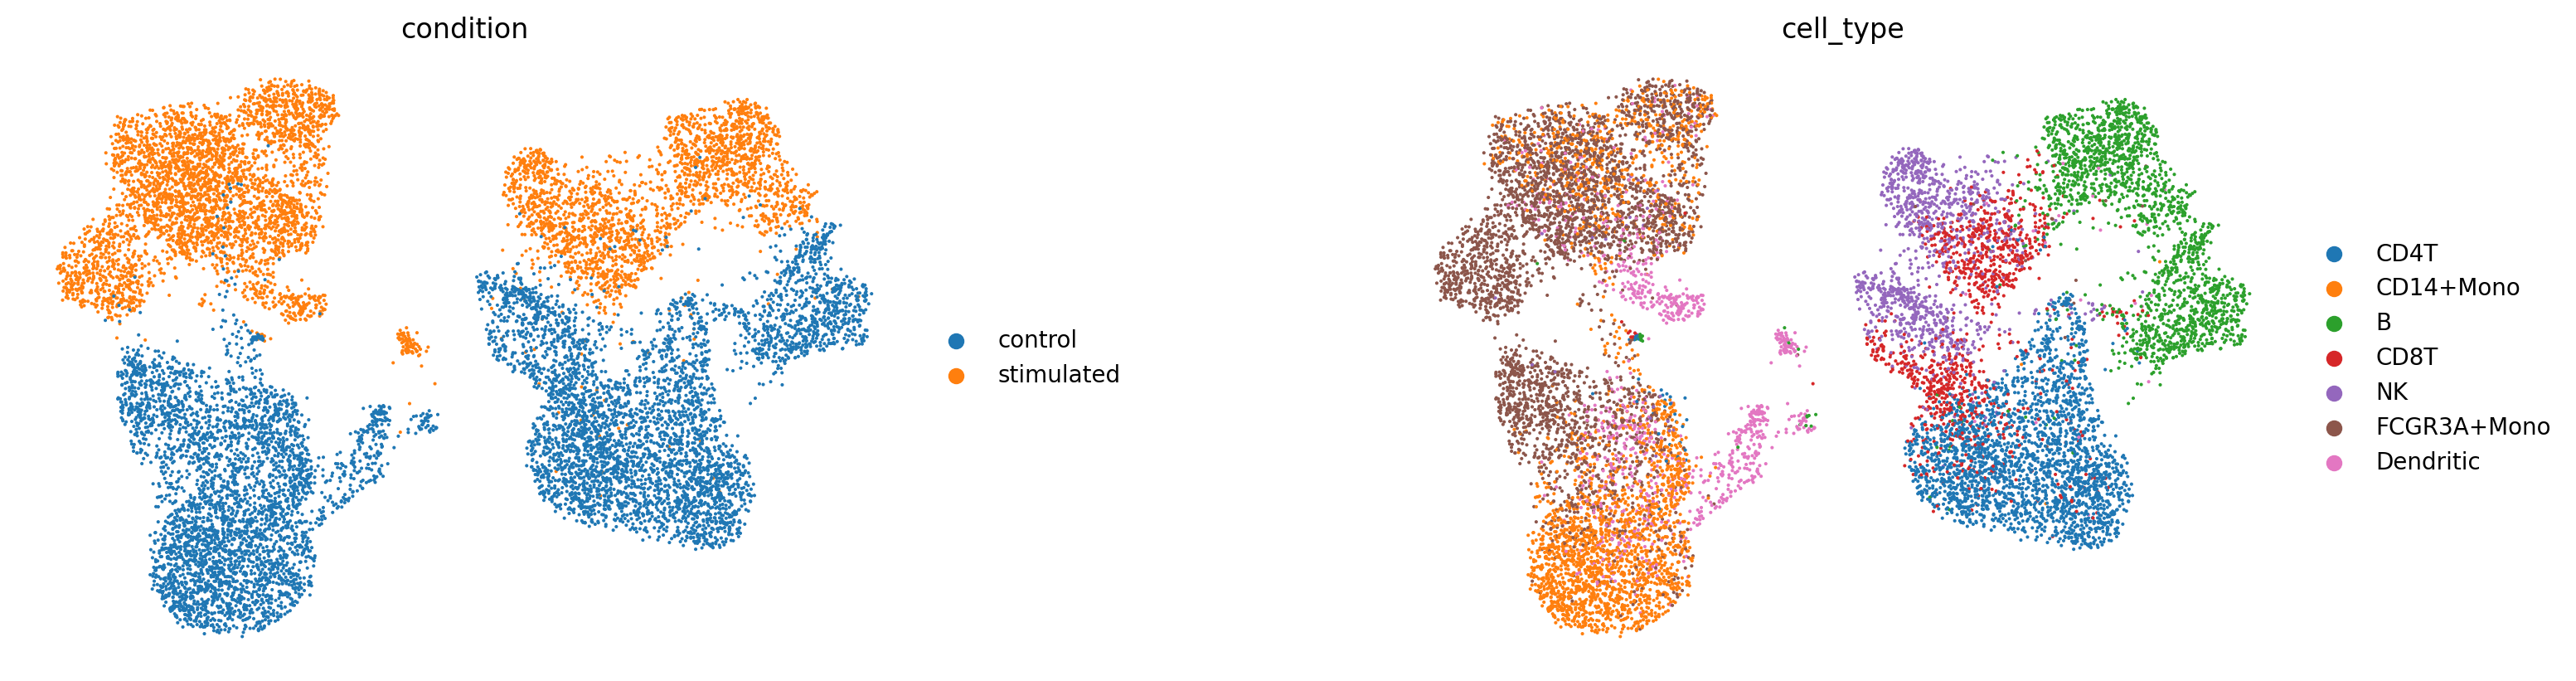

In [9]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_pbi.pdf')

#### Predict stimulated

In [10]:

def extractor(
    data,
    cell_type,
    condition_key,
    cell_type_key,
    ctrl_key,
    stim_key,
):
    """
    Returns a list of `data` files while filtering for a specific `cell_type`.
    """
    cell_with_both_condition = data[data.obs[cell_type_key] == cell_type]
    condition_1 = data[
        (data.obs[cell_type_key] == cell_type) & (data.obs[condition_key] == ctrl_key)
    ]
    condition_2 = data[
        (data.obs[cell_type_key] == cell_type) & (data.obs[condition_key] == stim_key)
    ]
    training = data[
        ~(
            (data.obs[cell_type_key] == cell_type)
            & (data.obs[condition_key] == stim_key)
        )
    ]
    return [training, condition_1, condition_2, cell_with_both_condition]


def balancer(
    adata,
    cell_type_key,
):
    """
    Makes cell type population equal.
    """
    class_names = np.unique(adata.obs[cell_type_key])
    class_pop = {}
    for cls in class_names:
        class_pop[cls] = adata[adata.obs[cell_type_key] == cls].shape[0]
    max_number = np.max(list(class_pop.values()))
    index_all = []
    for cls in class_names:
        class_index = np.array(adata.obs[cell_type_key] == cls)
        index_cls = np.nonzero(class_index)[0]
        index_cls_r = index_cls[np.random.choice(len(index_cls), max_number)]
        index_all.append(index_cls_r)

    balanced_data = adata[np.concatenate(index_all)].copy()
    return balanced_data

In [13]:
def get_latent_representation(autoencoder, adata, as_numpy=False):
    qz_m, qz_v, latent_X = autoencoder.encoder(torch.tensor(adata.to_df().values))
    if as_numpy:
        return latent_X.detach().numpy()
    else:
        return sc.AnnData(X=latent_X.detach().numpy(), obs=adata.obs.copy())


In [17]:


def predict(autoencoder, 
            adata, 
            celltype_to_predict):
    
    cell_type_key = 'cell_type'
    condition_key = 'condition'
    ctrl_x = adata[adata.obs[condition_key] == 'control', :]
    stim_x = adata[adata.obs[condition_key] == 'stimulated', :]
    
    # balance control and stimulated dataset
    ctrl_x = balancer(ctrl_x, cell_type_key)
    stim_x = balancer(stim_x, cell_type_key)
    
    # Get control adata (we predict stimulated for it)
    ctrl_pred = extractor(
            adata,
            celltype_to_predict,
            condition_key,
            cell_type_key,
            ctrl_key='control',
            stim_key='stimulated',
        )[1]

    # Equalize the sized od control and stimulated dataset
    eq = min(ctrl_x.X.shape[0], stim_x.X.shape[0])
    cd_ind = np.random.choice(range(ctrl_x.shape[0]), size=eq, replace=False)
    stim_ind = np.random.choice(range(stim_x.shape[0]), size=eq, replace=False)
    ctrl_adata = ctrl_x[cd_ind, :]
    stim_adata = stim_x[stim_ind, :]

    # compute mean of control/stimulated in latent space
    latent_ctrl = np.mean(get_latent_representation(autoencoder, ctrl_adata, as_numpy=True), axis=0)
    latent_stim = np.mean(get_latent_representation(autoencoder, stim_adata, as_numpy=True), axis=0)

    delta = latent_stim - latent_ctrl
    
    # get latent representation of anndata we want to predict stimulated for
    latent_cd = get_latent_representation(autoencoder, ctrl_pred, as_numpy=True)

    stim_pred = delta + latent_cd
    
    # decode predicted stimulated
    predicted_cells = (
        autoencoder.decoder(torch.Tensor(stim_pred)).cpu().detach().numpy()
    )

    predicted_adata = sc.AnnData(
        X=predicted_cells,
        obs=ctrl_pred.obs.copy(),
        var=ctrl_pred.var.copy(),
        obsm=ctrl_pred.obsm.copy(),
    )
    return predicted_adata, delta


predicted_adata, delta = predict(autoencoder, train_new, celltype_to_predict='CD4T')

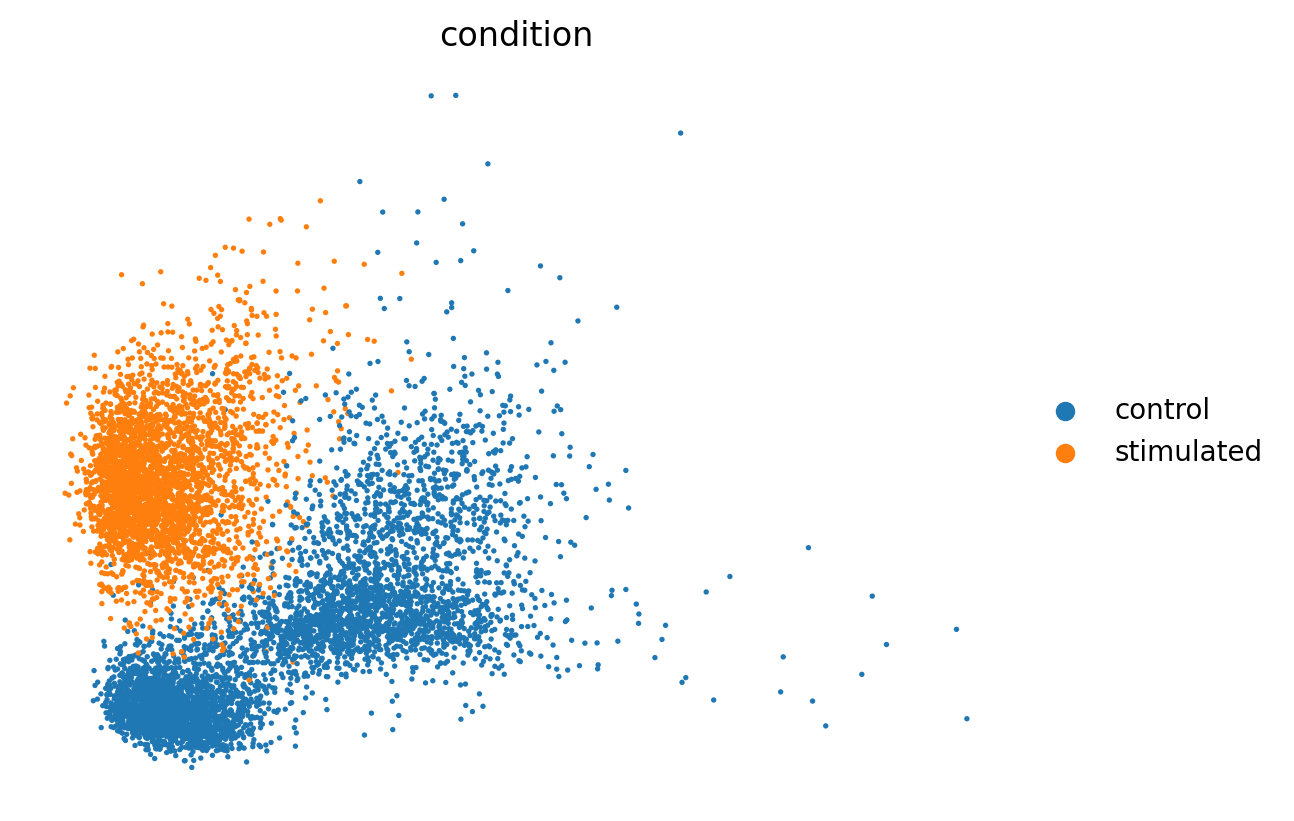

In [21]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

eval_adata = ctrl_adata.concatenate(stim_adata, predicted_adata)

sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_eval.pdf')

In [22]:
# # Danyil's early implementation

# class VariationalEncoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(VariationalEncoder, self).__init__()
#         self.linear1 = nn.Linear(784, 512)
#         self.linear2 = nn.Linear(512, latent_dims)
#         self.linear3 = nn.Linear(512, latent_dims)

#         self.N = torch.distributions.Normal(0, 1)
#         if device == 'cuda':
#             self.N.loc = self.N.loc.cuda()
#             self.N.scale = self.N.scale.cuda()
#         self.kl = 0

#     def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
#         x = F.relu(self.linear1(x))
#         mu = self.linear2(x)
#         sigma = torch.exp(self.linear3(x))
#         z = mu + sigma*self.N.sample(mu.shape)
#         self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
#         return z
    

# class Decoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(Decoder, self).__init__()
#         self.linear1 = nn.Linear(latent_dims, 512)
#         self.linear2 = nn.Linear(512, 784)

#     def forward(self, z):
#         z = F.relu(self.linear1(z))
#         z = torch.sigmoid(self.linear2(z))
#         return z.reshape((-1, 1, 28, 28))
    

# def train(autoencoder, data, epochs=20):
#     opt = torch.optim.Adam(autoencoder.parameters())
#     for epoch in range(epochs):
#         print(f"Epoch {epoch} is running...")
#         for x, y in data:
#             x = x.to(device)
#             opt.zero_grad()
#             x_hat = autoencoder(x)
#             print(x_hat.shape, x.shape)
#             loss = ((x - x_hat)**2).sum()
#             loss.backward()
#             opt.step()
#     return autoencoder


# def plot_latent(autoencoder, data, num_batches=100):
#     for i, (x, y) in enumerate(data):
#         z = autoencoder.encoder(x.to(device))
#         z = z.to('cpu').detach().numpy()
#         plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#         if i > num_batches:
#             plt.colorbar()
#             break
#     plt.show(block=True)
    

# def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
#     w = 28
#     img = np.zeros((n*w, n*w))
#     for i, y in enumerate(np.linspace(*r1, n)):
#         for j, x in enumerate(np.linspace(*r0, n)):
#             z = torch.Tensor([[x, y]]).to(device)
#             x_hat = autoencoder.decoder(z)
#             x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
#             img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
#     plt.imshow(img, extent=[*r0, *r1])
#     plt.show(block=True)
    
    

### Danyil's implementation for MNIST


In [23]:


class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        if device == 'cuda':
            self.N.loc = self.N.loc.cuda()
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    

def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch {epoch} is running...")
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            print(x_hat.shape, x.shape)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder


def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show(block=True)
    

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.show(block=True)
    
    

# SCGEN:  Perturbation Prediction <a class="anchor" id="scgen-perturbation-prediction"></a>

### Preprocessing Data

In [9]:
scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

In [10]:
train_new

AnnData object with n_obs × n_vars = 13766 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

## Creating and Saving the model¶

In [11]:
model = scgen.SCGEN(train_new)
model.save("../saved_models/model_perturbation_prediction.pt", overwrite=True)

## Training the Model

In [12]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|███████████████                                           | 26/100 [30:40<1:27:17, 70.78s/it, loss=72.7, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 518.420. Signaling Trainer to stop.


### Latent Space

In [13]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

         Falling back to preprocessing with `sc.pp.pca` and default params.


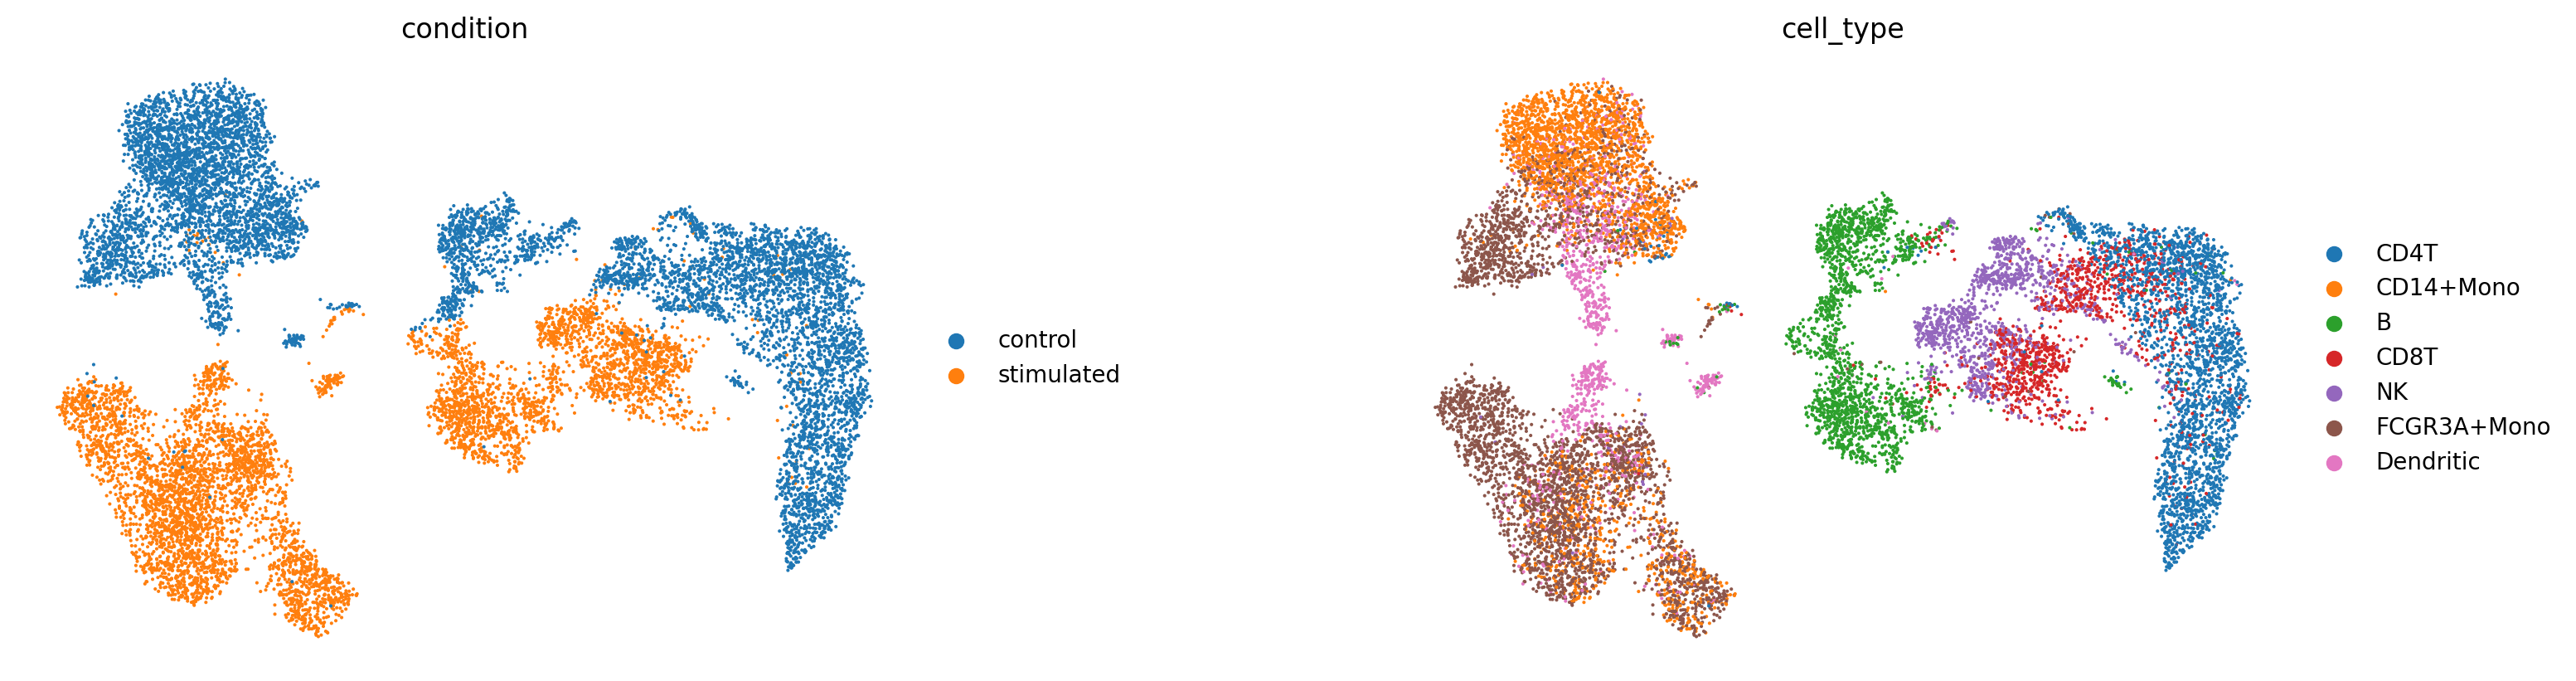

In [14]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

## Prediction

After training the model you can pass the adata of the cells you want to perturb. Here we pass unperturbed CD4T cells


Here the 'adata' contains the cells that you want estimate the perturbation based on them. we set "ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy matrix of our predicted cells and the second one is the difference vector between our conditions which might become useful later.

In [15]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)
pred.obs['condition'] = 'pred'

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells :

pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t, conditions={"ctrl": "control", "stim": "stimulated"}, cell_type_key="cell_type", condition_key="condition", obs_key={"cell_type": ["CD8T", "NK"]})`

## Evaluation of the predcition¶


#### Extracting both control and real stimulated CD4T cells from our dataset

In [16]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

AttributeError: 'function' object has no attribute 'obs'

Merging predicted cells with real ones

In [ ]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

### Embedding all real and predicted cells in one PCA plot¶

In [ ]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e.pdf')

## Mean correlation plot¶

You can also visualize your mean gene expression of your predicted cells vs control cells while highlighting your genes of interest (here top 10 differentially expressed genes)

In [ ]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

In [ ]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)

In [ ]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

You can also pass a list of differentially epxressed genes to compute correlation based on them

In [ ]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

### Violin plot for a specific gene¶


Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells

In [ ]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")